### Using orthogonal interpolation for deskewing

Using orthogonal interpolation for accurate interpolation of data when deskewing

Adapted from:
* https://spiral.imperial.ac.uk/bitstream/10044/1/68022/1/Maioli-V-2016-PhD-Thesis.pdf
* https://github.com/QI2lab/OPM/blob/master/reconstruction/image_post_processing.py#L34

The deskewing artefact is only obvious with highly anisotropic data. Orthogonal interpolation is a strategy to get rid of these artefacts

(59, 1828, 209)
Deskewing with bilinear interpolation


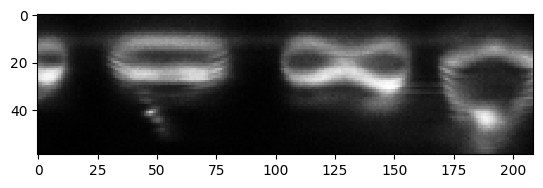

In [6]:
import math
import pyclesperanto_prototype as cle
from pyclesperanto_prototype._tier8._affine_transform import _determine_translation_and_bounding_box
from skimage.io import imread

#cle.select_device("NVIDIA")
#cle.get_device()

voxel_size_x_in_microns = 0.1449922
voxel_size_y_in_microns = 0.1449922
voxel_size_z_in_microns = 0.3

deskewing_angle_in_degrees = 30

original_image = imread("C:\\Users\\deepu\\OneDrive - wehi.edu.au\\WEHI_projects\\Lightsheet\\pyclesperanto_prototype\\data\\RBC_tiny.tif")

#Create anisotropic data
original_image = original_image[::3]
voxel_size_z_in_microns = voxel_size_z_in_microns * 3

#Defining Deskewing affine matrix
scale_factor = 1 #Scale factor is used in clesperanto if we want to scale the images in case they don't fit in memory

#initialise a transform
deskew_transform =cle.AffineTransform3D()
#Shear
shear_factor = math.sin((90 - deskewing_angle_in_degrees) * math.pi / 180.0) * (voxel_size_z_in_microns/voxel_size_y_in_microns)
deskew_transform._matrix[1, 2] = shear_factor
#Scale
new_dz = math.sin(deskewing_angle_in_degrees * math.pi / 180.0) * voxel_size_z_in_microns
scale_factor_z = (new_dz / voxel_size_y_in_microns) * scale_factor
deskew_transform.scale(scale_x=scale_factor, scale_y=scale_factor, scale_z=scale_factor_z)
#Rotate deskewing angle
deskew_transform.rotate(angle_in_degrees = 0 - deskewing_angle_in_degrees, axis=0)

_,deskew_transform,translation = _determine_translation_and_bounding_box(original_image, deskew_transform)


deskewed = cle.affine_transform(source= original_image,
                                transform = deskew_transform,
                                auto_size=True,
                                linear_interpolation=True)
print(deskewed.shape)
print("Deskewing with bilinear interpolation")
cle.imshow(deskewed[:,200])

Notice that the edges are "wavy". This is due to improper interpolation. 
pyclesperanto combines the deskewing workflow: shearing, scaling and rotation all into one affine transform.

Although, this makes things convenient, OpenCL will perform interpolation of neighbouring pixels from the input data. The neighbours in the input data are not the actual neighbours as the data is actually skewed. This can lead to image artefacts. 

OPM library implements deskewing using orthogonal interpolation and we have adapted this to pyclesperanto as below. 

To use orthogonal interpolation, use the function `affine_transform_deskew`

Using orthogonal interpolation:


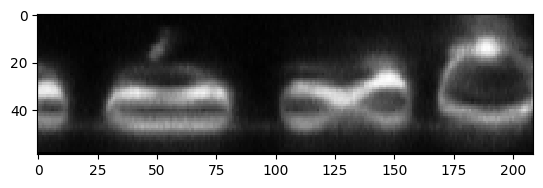

In [25]:
#Deskewing with orthogonal interpolation
import numpy as np 
deskewed_test_affine = cle.affine_transform_deskew(source= original_image,
                                            transform = deskew_transform,
                                            deskewing_angle_in_degrees=deskewing_angle_in_degrees,
                                            voxel_size_y = voxel_size_y_in_microns,
                                            voxel_size_z=voxel_size_z_in_microns,
                                            auto_size=True)
#import napari 
#viewer = napari.Viewer()

#deskewed_test_affine = np.asarray(deskewed_test_affine)
#deskewed_test_affine = np.flipud(deskewed_test_affine)

#viewer.add_image(deskewed_test_affine)
print("Using orthogonal interpolation:")
cle.imshow(deskewed_test_affine[:,200])

Extract of the code from OPM library below: 
THe code below is highly optimised for parallel processing on the CPU using `numba` 

https://github.com/QI2lab/OPM

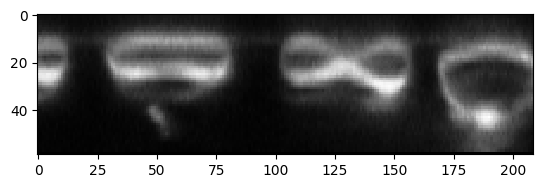

In [8]:
# Source: https://github.com/QI2lab/OPM/blob/master/reconstruction/image_post_processing.py
# Licensed GPL 3 https://github.com/QI2lab/OPM/blob/master/LICENSE

import sys
import numpy as np
from pathlib import Path
from numba import njit, prange
from functools import partial
import gc


    
# http://numba.pydata.org/numba-doc/latest/user/parallel.html#numba-parallel
@njit(parallel=True)
def deskew(data,theta,distance,pixel_size):
    """
    Perform parallelized orthogonal interpolation into a uniform pixel size grid.
    
    :param data: ndarray
        image stack of uniformly spaced OPM planes
    :param theta: float 
        angle relative to coverslip
    :param distance: float 
        step between image planes along coverslip
    :param pizel_size: float 
        in-plane camera pixel size in OPM coordinates
    :return output: ndarray
        image stack of deskewed OPM planes on uniform grid
    """

    # unwrap parameters 
    [num_images,ny,nx]=data.shape     # (pixels)

    # change step size from physical space (nm) to camera space (pixels)
    pixel_step = distance/pixel_size    # (pixels)

    # calculate the number of pixels scanned during stage scan 
    scan_end = num_images * pixel_step  # (pixels)

    # calculate properties for final image
    final_ny = np.int64(np.ceil(scan_end+ny*np.cos(theta*np.pi/180))) # (pixels)
    final_nz = np.int64(np.ceil(ny*np.sin(theta*np.pi/180)))          # (pixels)
    final_nx = np.int64(nx)                                           # (pixels)

    # create final image
    output = np.zeros((final_nz, final_ny, final_nx),dtype=np.float32)  # (time, pixels,pixels,pixels - data is float32)

    # precalculate trig functions for scan angle
    tantheta = np.float32(np.tan(theta * np.pi/180)) # (float32)
    sintheta = np.float32(np.sin(theta * np.pi/180)) # (float32)
    costheta = np.float32(np.cos(theta * np.pi/180)) # (float32)

    # perform orthogonal interpolation

    # loop through output z planes
    # defined as parallel loop in numba
    # http://numba.pydata.org/numba-doc/latest/user/parallel.html#numba-parallel
    for z in prange(0,final_nz):
        # calculate range of output y pixels to populate
        y_range_min=np.minimum(0,np.int64(np.floor(np.float32(z)/tantheta)))
        y_range_max=np.maximum(final_ny,np.int64(np.ceil(scan_end+np.float32(z)/tantheta+1)))

        # loop through final y pixels
        # defined as parallel loop in numba
        # http://numba.pydata.org/numba-doc/latest/user/parallel.html#numba-parallel
        for y in prange(y_range_min,y_range_max):

            # find the virtual tilted plane that intersects the interpolated plane 
            virtual_plane = y - z/tantheta

            # find raw data planes that surround the virtual plane
            plane_before = np.int64(np.floor(virtual_plane/pixel_step))
            plane_after = np.int64(plane_before+1)

            # continue if raw data planes are within the data range
            if ((plane_before>=0) and (plane_after<num_images)):
                
                # find distance of a point on the  interpolated plane to plane_before and plane_after
                l_before = virtual_plane - plane_before * pixel_step
                l_after = pixel_step - l_before
                
                # determine location of a point along the interpolated plane
                za = z/sintheta
                virtual_pos_before = za + l_before*costheta
                virtual_pos_after = za - l_after*costheta

                # determine nearest data points to interpoloated point in raw data
                pos_before = np.int64(np.floor(virtual_pos_before))
                pos_after = np.int64(np.floor(virtual_pos_after))

                # continue if within data bounds
                if ((pos_before>=0) and (pos_after >= 0) and (pos_before<ny-1) and (pos_after<ny-1)):
                    
                    # determine points surrounding interpolated point on the virtual plane 
                    dz_before = virtual_pos_before - pos_before
                    dz_after = virtual_pos_after - pos_after

                    # compute final image plane using orthogonal interpolation
                    output[z,y,:] = (l_before * dz_after * data[plane_after,pos_after+1,:] +
                                    l_before * (1-dz_after) * data[plane_after,pos_after,:] +
                                    l_after * dz_before * data[plane_before,pos_before+1,:] +
                                    l_after * (1-dz_before) * data[plane_before,pos_before,:]) /pixel_step


    return output


deskewed_opm = deskew(original_image,deskewing_angle_in_degrees,voxel_size_z_in_microns,voxel_size_x_in_microns)
cle.imshow(deskewed_opm[:,200][::-1])

In [19]:
theta = 30# precalculate trig functions for scan angle
distance = 0.3
pixel_size = 0.145


# unwrap parameters 
[num_images,ny,nx]=original_image.shape     # (pixels)
# change step size from physical space (nm) to camera space (pixels)
pixel_step = distance/pixel_size    # (pixels)
# calculate the number of pixels scanned during stage scan 
scan_end = num_images * pixel_step  # (pixels)
# calculate properties for final image
final_ny = np.int64(np.ceil(scan_end+ny*np.cos(theta*np.pi/180)))
    

tantheta = np.float32(np.tan(theta * np.pi/180)) # (float32)
sintheta = np.float32(np.sin(theta * np.pi/180)) # (float32)
costheta = np.float32(np.cos(theta * np.pi/180)) # (float32)

z= 50
y = 100
y_range_min=np.minimum(0,np.int64(np.floor(np.float32(z)/tantheta)))
y_range_max=np.maximum(final_ny,np.int64(np.ceil(scan_end+np.float32(z)/tantheta+1)))  



virtual_plane = y - z/tantheta

# find raw data planes that surround the virtual plane
plane_before = np.int64(np.floor(virtual_plane/pixel_step))
plane_after = np.int64(plane_before+1)

print(plane_before)
print(plane_after)
# determine location of a point along the interpolated plane
za = z/sintheta
l_before = virtual_plane - plane_before * pixel_step
l_after = pixel_step - l_before
virtual_pos_before = za + l_before*costheta
virtual_pos_after = za - l_after*costheta
# determine nearest data points to interpoloated point in raw data
pos_before = np.int64(np.floor(virtual_pos_before))
pos_after = np.int64(np.floor(virtual_pos_after))

print(virtual_pos_before, virtual_pos_after)

print(pos_before, pos_after)

6
7
100.85187883212649 99.06010216680066
100 99
